#### Tomography

X-ray tomography of a cross-section of a body can be considered scanning this cross-section image using rotating parallel X-rays and determine how much each X-ray is attenuated due to interacting with what is inside the body

Tomography can be simplified to a least sqaures problem by
* discretizing cross-section into an image of discrete `pixels`
* `scanning` this image using rotating parallel X-rays
* for each X-ray traversing the image, the measurement of its intensity is directly related to its attenuation, which we can compute as sum of pixel intensity of all image pixels, weighted by the length that the ray `intersects` with each pixel

Since the measurement is a linear combination of all pixel intensities, we can treat all measurements as a vector `y` of length `n_meas`, establish a measurement matrix `A` with `n_meas` rows and `n_pixel` columns, and flatten the image `x` into a `n_pixel` vector, and solve the least squares problem `y=Ax` to recover `x`

#### `Coordinates` of pixels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from skimage.data import shepp_logan_phantom
from skimage.transform import rescale, resize

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

[[ 1.0  1.0  1.0  1.0]
 [ 2.0  2.0  2.0  2.0]
 [ 3.0  3.0  3.0  3.0]
 [ 4.0  4.0  4.0  4.0]]


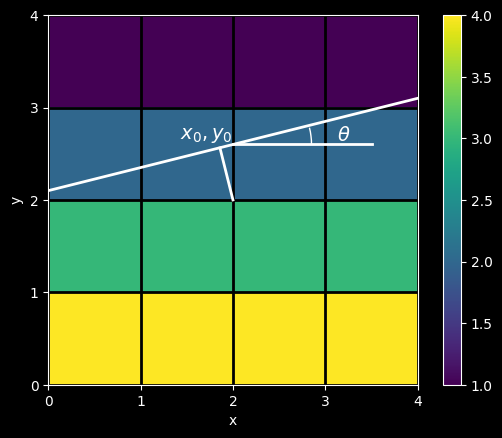

In [ ]:
np.random.seed(42)

n_grid = 4
grid = np.ones((n_grid, n_grid)) * np.array([[1], [2], [3], [4]])
print(grid)
theta = np.arctan(0.25)
d = 0.58

fig, ax = plt.subplots()
cax = ax.imshow(grid, extent=[0, n_grid, 0, n_grid], origin='upper')

ax.plot([0,n_grid],[n_grid/2+0.1, n_grid/2+1.1],'w',linewidth=2)
ax.plot([n_grid/2, n_grid/2+1.5],[n_grid/2+0.6, n_grid/2+0.6],'w',linewidth=2)
ax.text(n_grid/2+1.2, n_grid/2+0.7, r'$\theta$', horizontalalignment='center', verticalalignment='center', fontsize=14, color='w')
theta_arc = Arc((n_grid/2+0.1, n_grid/2+0.6), 1.5,1.5, theta1=0, theta2=np.rad2deg(theta), color='w', zorder=4)
ax.add_patch(theta_arc)
ax.plot([n_grid/2, n_grid/2-d*np.sin(theta)],[n_grid/2, n_grid/2+d*np.cos(theta)],'w',linewidth=2)
ax.text(n_grid/2, n_grid/2+0.7, r'$x_0, y_0$', horizontalalignment='right', verticalalignment='center', fontsize=14, color='w')


ax.set_xticks(np.arange(0, n_grid+1, 1))
ax.set_yticks(np.arange(0, n_grid+1, 1))
ax.grid(which='both', color='black', linestyle='-', linewidth=2)

ax.set_xlabel('x')
ax.set_ylabel('y')

# plt.gca().invert_yaxis()
plt.colorbar(cax)
plt.show()

#### Function to compute length of intersection for each pixel given a ray

In [ ]:
def get_intersection(d, theta, n):
    # For angles in [0, pi/4], no transform needed

    # For angles in [pi/4, 3*pi/4], flip along diagonal and transpose result
    # Essentially solving for [-pi/4, pi/4]
    if np.pi/4 < theta < 3*np.pi/4:
        return get_intersection(d, np.pi/2 - theta, n).T

    # For angles in [3*pi/4, pi], redefine the line to go in opposite direction
    # This converts the problem into [-pi/4, 0], handled below
    if theta > np.pi/2:
        d = -d
        theta = theta - np.pi

    # For angles in [-pi/4, 0], flip along w.r.t. x-axis
    # Essentially solving for [0, pi/4]
    if theta < 0:
        return np.flipud(get_intersection(-d, -theta, n))

    # Ensure theta is within the valid range [0, pi/4], since it should have been adjusted by now
    if theta > np.pi/4 or theta < 0:
        print('Invalid angle')
        return None

    intersect_mat = np.zeros((n, n))

    # Projection of center of grid to the ray
    x0 = n / 2 - d * np.sin(theta)
    y0 = n / 2 + d * np.cos(theta)

    # y intercept
    y = y0 - (x0 - 0) * np.tan(theta) # where ray intersects left boundary of the grid

    # Find the pixel row index where the ray enters the grid (which is not row index of array)
    y_idx = int(np.ceil(y)) # 2.1 -> 3 from which pixel does ray enter the grid (index start from 1, so it can be compared to grid size)

    # Distance from intecept to boundary with pixel below 2.1 -> 0.1
    dy = (y + n) % 1

    # Loop through columns
    for x_idx in range(n):
        dy_next = dy + 1 * np.tan(theta) # where the ray intersects the boundary between current pixel COLUMN and next pixel COLUMN

        # When ray enters next column from a pixel that is within the SAME ROW of current pixel
        # This means, for current column, the ray passes through a single pixel
        if dy_next < 1:
            # When current row is within the grid
            if 1 <= y_idx <= n:
                intersect_mat[n - y_idx, x_idx] = 1 / np.cos(theta)  # Intersection length of current pixel
            dy = dy_next  # Move to next iteration with updated distance of intercept to the edge of pixel below

        # When ray enters next column from a pixel that is ABOVE the row of current pixel
        # This means, for current column, the ray passes through two pixels
        # Conditions at beginning limits theta within 0 to pi/4, so a ray cannot pass through more than two pixels in the same column
        else:
            # When current row is within the grid
            if 1 <= y_idx <= n:
                intersect_mat[n - y_idx, x_idx] = (1 - dy) / np.sin(theta)  # Intersection length of current pixel

            # When the row above is also within the grid
            if 1 <= y_idx + 1 <= n:
                intersect_mat[n - (y_idx + 1), x_idx] = (dy_next - 1) / np.sin(theta)  # Intersection length of pixel above, note top row of pixel is first row of array

            dy = dy_next - 1 # Since the ray intesects next column one row above, we need to substract one to get distance between intecept to pixel below
            y_idx += 1  # Also add one to pixel row index

    return intersect_mat

#### Simulate measurement by applying `get_intersection` for difference offset and angle

In [ ]:
def get_measurement(img, n_grid=30, n_ray=35, n_theta=35, sigma=0.7):
    # Flatten image into a vector
    x = img.flatten()

    # Total measurements
    n_meas = n_ray * n_theta

    y = np.zeros(n_meas)  # measure from each line
    d_list = np.zeros(n_meas)  # d of each line
    theta_list = np.zeros(n_meas)  # theta of each line

    # Loop over each angle and displacement to perform measurements
    i=0
    intersect_vec_mat = np.empty((n_meas, len(x)))
    for i_theta in range(n_theta):
        for i_d in range(n_ray):
            # Get displacement for equally spaced parallel lines
            # Full coverage needs 1.4 * n_grid total span, for angle at pi/4
            d_list[i] = 0.7 * n_grid * (i_d - n_ray / 2 - 0.5) / (n_ray / 2)

            # Get angle, equally spaced from 0 to pi
            theta_list[i] = np.pi * i_theta / n_theta

            # Get length of intersection with each pixel (a matrix)
            intersect_mat = get_intersection(d_list[i], theta_list[i], n_grid)

            # Flatten matrix into vector
            intersect_vec = intersect_mat.flatten()

            intersect_vec_mat[i] = intersect_vec

            # Compute line integral as weighted sum + noise
            y[i] = np.dot(intersect_vec, x) + np.random.normal(0, sigma)

            i += 1

    return y, d_list, theta_list, intersect_vec_mat

#### `Regularized` least squares solution to recover image

Here, we assume that we have less number of measurements than number of pixels, that is `n_ray * n_theta < n_grid **2`

In such case, the least squares problem becomes `underdetermined`, as there are infinite number of possible solutions

Therefore, we need to use `regularization` to constrain the solution to the ones that have the desired properties

We compare two simple regularizations here
* $l_2$ regularization, which says that the `sum of squares` of all pixel intensities should not be too large
* Laplacian regularization, which says that each pixel should not be too different from its four `neighbouring pixels` in terms of intensity

(900,)
(900,)
(900,)
(900, 1600)


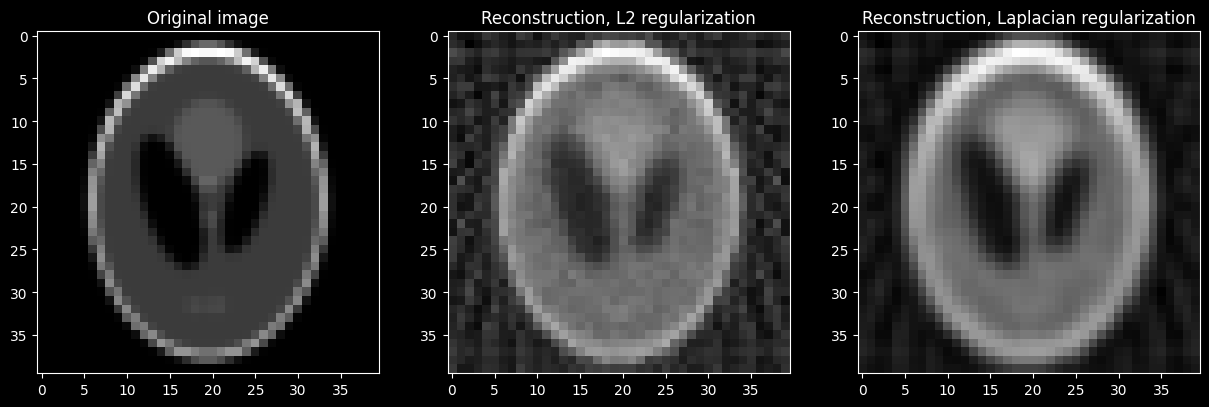

In [ ]:
n_grid = 40
n_ray = 60
n_theta = 15
sigma = 0.1

img = shepp_logan_phantom()
img = resize(img, (n_grid, n_grid))

y, d_list, theta_list, A = get_measurement(img, n_grid, n_ray, n_theta, sigma)

print(y.shape)
# print(np.max(y))
print(d_list.shape)
print(theta_list.shape)
print(A.shape)

# Least squares with l2 regularization
lambda_l2=10
x_ls = np.linalg.inv(A.T @ A+lambda_l2*np.eye(A.shape[1])) @ A.T @ y
img_ls = x_ls.reshape(n_grid, n_grid)

# Least squares with Laplacian regularization
# Minimize sum of squared difference of pixels from their 4 neighbours
def laplacian_matrix(n_grid):
    n_pixel = n_grid ** 2
    laplacian_mat = np.zeros((n_pixel, n_pixel))

    for i in range(n_pixel):
        # Main diagonal of Laplacian matrix
        # -4 comes from 2D discrete Laplacian operator
        # each pixel is subtracted from its four neighbors
        # Main diagonal stores weight of central pixel
        # since it's compared to its four neighbors, the value is -4
        laplacian_mat[i, i] = -4

        # Weights for neighbour to the left and right of central pixel
        if i % n_grid != 0: # not for left most pixel
            laplacian_mat[i, i - 1] = 1
        if (i + 1) % n_grid != 0: # not for right most pixel
            laplacian_mat[i, i + 1] = 1

        # Weights for neighbour on the top and bottom of central pixel
        if i >= n_grid:  # not for top pixel
            laplacian_mat[i, i - n_grid] = 1
        if i < n_pixel - n_grid:  # not for bottom pixel
            laplacian_mat[i, i + n_grid] = 1

    return laplacian_mat

laplacian_mat = laplacian_matrix(n_grid)
lambda_laplace = 10
x_laplacian = np.linalg.inv(A.T @ A + lambda_laplace * (laplacian_mat.T @ laplacian_mat)) @ A.T @ y
img_laplacian = x_laplacian.reshape(n_grid, n_grid)

fig_2, ax_2 = plt.subplots(1, 3, figsize=(15, 5))
ax_2[0].imshow(img, cmap='gray')
ax_2[0].set_title('Original image')
ax_2[1].imshow(img_ls, cmap='gray')
ax_2[1].set_title('Reconstruction, L2 regularization')
ax_2[2].imshow(img_laplacian, cmap='gray')
ax_2[2].set_title('Reconstruction, Laplacian regularization')
plt.show()